# Projet 5 : Segmentez les comportements de clients
# <u>B. Segmentation des clients</u> <br/>

# Le contexte

Notre employeur Datazon souhaite mieux comprendre le comportements de ses clients afin de faire de meilleures ventes et augmenter son chiffre d'affaire.

Notre **objectif** est de mieux comprendre les clients afin de les classer en catégories et de déterminer automatiquement la catégorie d'un client dès son premier achat.

Ce notebook traite de la partie recherche de segmentation des clients. Nous avons fait de nombreux tests avec différentes features mais nous n'avons garder dans ce notebook que ceux qui ont donnés des résultats intéressants. Exemple de features : catégorie de produit (en fonction du tarif unitaire), min max quantité, score RFM, découpage mensuel, données sur 1 an et 3 derniers mois, ...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import  manifold, cluster
from IPython.display import display

%matplotlib inline

# 1. Importation des données

On charge les données traitées par l'analyse exploratoire.

In [2]:
df= pd.read_csv('orders.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth,Canceled,Discount,Promotion,UK,ProductCategory
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,0,0,0,1,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0,1,3
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,0,0,0,1,3
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0,1,3
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0,1,3


# 2. Données d'achat par commande

On commence par regrouper les informations de chaque commande

In [76]:
'''
Create from the transactions data a new dataframe containing information group by customer and by invoice
'''
def createDataStructureByOrders(data) :
    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
    o_data = temp.rename(columns = {'TotalPrice':'OrderPrice'})

    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Quantity'].sum()
    o_data.loc[:, 'OrderQuantity'] = temp['Quantity']

    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Canceled'].sum()
    o_data.loc[:, 'OrderCanceled'] = temp['Canceled']

    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Discount'].sum()
    o_data.loc[:, 'OrderDiscount'] = temp['Discount']

    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Promotion'].sum()
    o_data.loc[:, 'OrderPromo'] = temp['Promotion']


    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['UK'].sum()
    o_data.loc[:, 'isUK'] = temp['UK']

    data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
    data['InvoiceDate_int'] = data['InvoiceDate'].astype('int64')
    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
    data.drop('InvoiceDate_int', axis = 1, inplace = True)
    o_data.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
    return o_data

In [83]:
orders_data=createDataStructureByOrders(df)
display(orders_data.head())

,CustomerID,InvoiceNo,OrderPrice,OrderQuantity,OrderCanceled,OrderDiscount,OrderPromo,isUK,InvoiceDate
0,12346.0,541431,77183.60,74215,0,0,0,1,2011-01-18 10:01:00.000000000
1,12346.0,C541433,-77183.60,-74215,1,0,0,1,2011-01-18 10:17:00.000000000
2,12347.0,537626,711.79,319,0,0,0,0,2010-12-07 14:57:00.000001024
3,12347.0,542237,475.39,315,0,0,0,0,2011-01-26 14:29:59.999999744
4,12347.0,549222,636.25,483,0,0,0,0,2011-04-07 10:42:59.999999232


### Jeu d'entrainement et tests

Pour ne pas biaiser la classification, nous séparons les données en jeu d'entrainement et de tests. Nous allons faire notre clustering sur les données d'entrainement puis appliquer nos modèles d'apprentissage pour la classification. On va ensuite vérifier avec les données de tests.

In [84]:
msk = np.random.rand(len(orders_data)) < 0.8
train_orders = orders_data[msk]
test_orders = orders_data[~msk]

In [85]:
print('Nb customers in training set : ', train_orders['CustomerID'].nunique())
print('Nb customers in testing set  : ', test_orders['CustomerID'].nunique())

Nb customers in training set :  4076
Nb customers in testing set  :  2159


# 3. Données d'achats par client

## Création de la structure

Pour chaque client, on construit une structure qui contient les élèments de son panier moyen : 
    - nombre d'achats, total dépensé, dépense panier moyen, quantité de produits, et prix unitaire moyen.

In [89]:
'''
Regroupement des données d'achats par client.
'''

def createDataStructureByCustomer(orders_d) :
    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].agg(['count'])
    c_data=temp.rename(columns={'count': 'NbOrders'})
    c_data.reset_index(drop = False, inplace = True)

    temp = orders_d.groupby(by=['CustomerID','InvoiceNo'], as_index=False)['OrderPrice'].sum()
    temp = temp.groupby(by=['CustomerID'])['OrderPrice'].agg(['sum','mean','min','max'])
    temp=temp.rename(columns={'sum':'TotalSpent', 'mean':'AverageSpent','min':'MinSpent','max':'MaxSpent'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderQuantity'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'TotalQuantity'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderCanceled'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'NbCanceled'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderDiscount'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'NbDiscount'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderPromo'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'NbPromo'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False).agg({'isUK': lambda x: 1 if (x.all()>0) else 0})
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    dtmax = orders_d.InvoiceDate.max()
    now = dt.datetime(dtmax.year, dtmax.month, dtmax.day) + dt.timedelta(days=1)
    temp = orders_d.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days})
    temp=temp.rename(columns={'InvoiceDate': 'LastPurchase'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')
    return c_data

On créé notre structure de données par client à partir du jeu de données d'entrainement'

In [86]:
customers_data = createDataStructureByCustomer(train_orders)

In [88]:
display(customers_data.head())
customers_data.shape

,CustomerID,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase
0,12346.0,2,0.00,0.00,-77183.60,77183.60,0,1,0,0,1,325
1,12347.0,3,1082.73,360.91,224.82,475.39,703,0,0,0,0,2
2,12348.0,3,1249.80,416.60,270.00,652.80,1732,0,0,0,0,75
3,12349.0,1,1457.55,1457.55,1457.55,1457.55,630,0,0,0,0,18
4,12350.0,1,294.40,294.40,294.40,294.40,196,0,0,0,0,310


(4076, 12)

# 4. Partitionnement des données avec KMeans

#### Construction de la matrice données

Commençons par créer une matrice sur laquelle nous pourront appliquer nos algorithmes de clustering

In [90]:
X = customers_data.drop(['CustomerID'], axis=1)

#### Utilisation des quantiles pour valoriser les données de chacune des variables

On classe les données en 4 groupes correspondant en quantile. Celà facilitera le partionnement en cluster avec des clusters un peu plus homogènes.

- 1 = faible
- 2 = moyen
- 3 = élevé
- 4 = très élevé

In [91]:
# On attribue un score en fonction de quantile d'appartenance de la donnée
def getScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

# Calcul score pour les données dont la valorisation est plus importance si la valeur est faible
# Ex : LastPurchase. Plus la valeur est petite, plus l'achat est récent donc à une valorisation importante pour nous.
def getRScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [93]:
# Transforme les données en score de quantile et retourne une matrice
def createQuantileMatrix(X) :
    quantiles = X.quantile(q=[0.25,0.5,0.75])
    quantiles = quantiles.to_dict()
    X_std=X.copy()
    for column in X:
        if (column == 'LastPurchase') :
            X_std[column] = X[column].apply(getRScore, args=(column,quantiles,))
        else :
            X_std[column] = X[column].apply(getScore, args=(column,quantiles,))
    return X_std

In [94]:
X_std = createQuantileMatrix(X)

### Calcul du coefficient de silhouette par cluster

On se limite à chercher au maximum 13 clusters car sinon la segmentation sera trop fine et difficilement utilisable par le service marketing.

In [ ]:
'''
Calcul et affichage du coefficient de silhouette pour chaque valeur de k allant de 2 à 13.
'''
def kmeans_silhouette_score(X_std) :
    cluster_range = range( 2, 13 )
    silhouettes = []
     
    # on calcule le score de silhouette pour un nombre de clusters    
    for n_clusters in cluster_range:
        clusterer = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
        cluster_labels = clusterer.fit_predict( X_std )
    
        silhouette_avg = silhouette_score(X_std, cluster_labels)
        silhouettes.append(silhouette_avg)
        print("Pour n_clusters =", n_clusters,
            "La moyenne du score de silhouette est : {:<.3f}".format(silhouette_avg))

    # On affiche sous forme de graphe
    plt.step(cluster_range, silhouettes, where='mid',label='cumulative explained variance')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de silhouette')

    plt.show() 

On applique l'algorithme de KMeans sur nos données. 

In [ ]:
kmeans_silhouette_score(X_std)

- Nous obtenons les meilleurs score à k =2 ou k=3 mais nous voulons au moins 4 segments. On peut considérer qu'avec k=5 on a le 3ème meilleur score et on a un nombre raisonnable de catégories clients.

Nous partons donc sur 5 clusters et faisons les prédictions de labels avec l'algorithme **Kmeans**.

In [138]:
n_clusters = 5
k_means_cluster = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
cluster_labels = k_means_cluster.fit_predict( X_std )

### Silhouette plot

Affichage du score de silhouette intra cluster pour voir si les clusters sont bien homogènes.

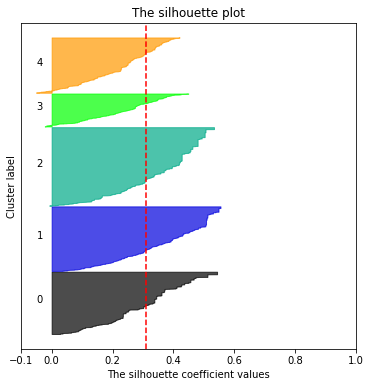

In [112]:
sample_silhouette_values = silhouette_samples(X_std, cluster_labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(6, 6)
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

silhouette_avg = silhouette_score(X_std, cluster_labels)

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

=> Le resultat est satisfaisant.

### Répartition des clients

In [113]:
pd.DataFrame(pd.Series(cluster_labels).value_counts(), columns = ['NbCustomers']).sort_values(by='NbCustomers',ascending=False).T

,2,1,0,4,3
NbCustomers,1089,897,865,768,457


La répartition est assez équilibrée entre les différents clusters.

#### Affichage des clusters

Utilisons TSNE pour afficher les clusters en 2 dimensions.

In [114]:
tsne = manifold.TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(X_std)

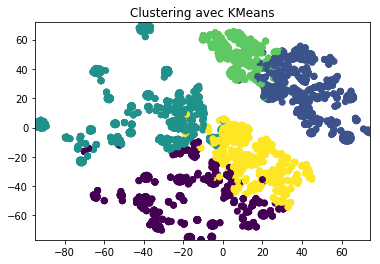

In [115]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels)
plt.xlim([np.min(tsne_results[:, 0]), np.max(tsne_results[:, 0])])
plt.ylim([np.min(tsne_results[:, 1]), np.max(tsne_results[:, 1])])
plt.title('Clustering avec KMeans')

# 5. Interprétation des segments

On ajoute les numéro de cluster à notre table

In [116]:
customers_data["Cluster"]= cluster_labels

In [117]:
customers_data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4076.0,15292.613101,1728.687648,12346.0,13798.750000,15279.500,16782.500000,18287.00
NbOrders,4076.0,4.276742,7.499036,1.0,1.000000,2.000,5.000000,188.00
TotalSpent,4076.0,1631.029438,7033.019904,-1192.2,265.827500,568.340,1344.375000,236492.42
AverageSpent,4076.0,320.275254,420.793583,-1192.2,148.525313,237.675,370.076667,13305.50
MinSpent,4076.0,83.500000,2949.020241,-168469.6,-11.412500,110.550,252.832500,6207.67
MaxSpent,4076.0,625.740633,3176.497206,-1192.2,205.287500,344.710,588.352500,168469.60
TotalQuantity,4076.0,962.522571,3985.353504,-303.0,137.750000,327.000,814.750000,165008.00
NbCanceled,4076.0,1.702895,6.185302,0.0,0.000000,0.000,1.000000,154.00
NbDiscount,4076.0,0.016438,0.512398,0.0,0.000000,0.000,0.000000,31.00
NbPromo,4076.0,0.007360,0.119075,0.0,0.000000,0.000,0.000000,4.00


In [118]:
clusters_df = pd.DataFrame()
for i in range(n_clusters):
    mean_data = pd.DataFrame(customers_data[customers_data['Cluster'] == i].mean())
    mean_data = mean_data.T.set_index('Cluster', drop = True)
    mean_data['size'] = customers_data[customers_data['Cluster'] == i].shape[0]
    clusters_df = pd.concat([clusters_df, mean_data])

clusters_df.drop('CustomerID', axis = 1, inplace = True)

clusters_df = clusters_df.sort_values('size')
clusters_df

,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase,size
Cluster,,,,,,,,,,,,
3.0,3.102845,319.497155,87.874945,-589.038884,762.960788,181.840263,3.150985,0.002188,0.008753,0.892779,130.829322,457
4.0,4.691406,2122.207305,452.462418,246.347865,737.522604,1212.580729,0.000000,0.000000,0.002604,0.893229,45.466146,768
0.0,1.250867,609.350393,490.510505,456.392162,539.584220,330.310983,0.000000,0.000000,0.001156,0.869364,136.872832,865
1.0,10.738016,4580.911594,377.291254,-124.348774,1108.887670,2745.522854,6.132664,0.073579,0.024526,0.889632,38.362319,897
2.0,1.558310,216.753710,142.396791,125.898292,159.794114,147.314968,0.000000,0.000000,0.000918,0.943985,133.800735,1089


### Analyse

|         | NbOrders | TotalSpent | AverageSpent |MinSpent | MaxSpent |TotalQuantity | NbCanceled |NbDiscount |NbPromo |isUK |LastPurchase |
|---------|-----------------|-----------------|-----------------|-----------------|-----------------|
|Mediane  |     2         | 568         |         237	    | 110            | 344 |327 | 0 | 0 | 0 | 1 | 54 |

- Cluster 1 (#2) : **clients fidèles** : client qui achètent régulièrement et qui on un panier moyen très élevé. Ce sont aussi ceux qui annulent le plus et ceux qui sont intéressés par les remises (discount) et les promotions. 
- Cluster 4 (#4) : **clients à haute valeur** : Ils ont un panier moyen très élevés et reviennent assez régulièrement. Ce sont essentiellement des clients Anglais.
- Cluster 0 (#3) : **clients à potentiel** : clients rares mais qui ont un panier moyen le plus élevé. Mais ils ne sont pas revenus depuis quelques mois et ont fait légerement plus d'un achat sur la plateforme. Ce sont des clients à relancer pour développer les ventes.
- Cluster 3 (#5) : **clients standards** : clients qui ont acheté plusieurs fois mais dans la moyenne et en petite quantité. Ils ne sont pas revenus depuis quelques mois et semblent intéressés par les remises et promos.
- Cluster 2 (#1) : **clients à faible valeur ** : ils ont acheté en moyenne moins de 2 fois et ont un panier plus faible que la moyenne. Ce sont des client qui ne sont pas revenus depuis en moyenne 4 mois.




# 6. Test de partionnement avec DBScan

In [123]:
from sklearn.cluster import DBSCAN


X = customers_data.drop(['CustomerID','Cluster'], axis=1).as_matrix()
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

dbscan = DBSCAN(eps = 0.1, min_samples = 20)
dbscan.fit(X_std)
print(dbscan.labels_)

[-1 -1 -1 ..., -1 -1 -1]


In [124]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 5


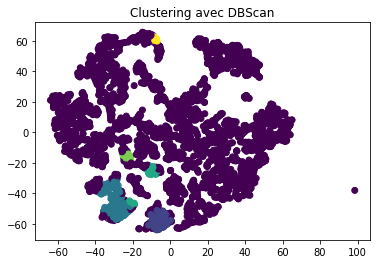

In [125]:
tsne = manifold.TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(X_std)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels)
plt.title('Clustering avec DBScan')

=> Les groupes sont moins équilibrés qu'avec KMeans. Nous conservons le découpage KMeans.

# 7. Sauvegarde des données 

In [135]:
customers_data.to_csv('customers_data.csv', index=False)
train_orders.to_csv('train_orders.csv', index=False)
test_orders.to_csv('test_orders.csv', index=False)

In [139]:
from sklearn.externals import joblib
joblib.dump(k_means_cluster, 'kmeans_cluster.pkl')

['kmeans_cluster.pkl']